In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/instquality/")

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/instquality/")

import warnings
warnings.filterwarnings("ignore")

# Set-up


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_pickle("saved/inst.dat")

In [ ]:
# drop redundant cols

from functions.labels import *

label_dicts = {
    "tgt": tgt_labels,
    "fiw": fiw_labels,
    "ief": ief_labels,
    "efw": efw_labels,
    "pts": pts_labels,
    "p5d": p5d_labels,
    "wb_iq": wb_iq_labels,
    "wgi": wgi_labels,
    "controls": controls_labels,
}

keep_cols = ['country', 'year', 'iso_code_1','iso_code_2', 'region'] + [v for d in label_dicts.values() for v in d.keys()]
dropped = [c for c in df.columns if c not in keep_cols]
df = df[[c for c in df.columns if c in keep_cols]].copy()
print(f"Kept {len(df.columns)} cols, dropped {len(dropped)}")

Kept 136 cols, dropped 83


In [ ]:
# create lagged target var, drop other target vars

from functions.utils import prep_target

df = prep_target(df)

In [ ]:
# drop obs without target var

b_obs, b_cty = len(df), df["country"].nunique()
df = df.dropna(subset=["tgt_spread_lag"]).copy().reset_index(drop=True)
a_obs, a_cty = len(df), df["country"].nunique()

print(f"Kept {a_cty} countries, dropped {b_cty - a_cty}\nKept {a_obs:,} obs, dropped {(b_obs - a_obs):,}")

df.head()

Kept 71 countries, dropped 127
Kept 2,183 obs, dropped 10,355


,country,year,iso_code_1,iso_code_2,region,tgt_spread_lag,tgt_spread,efw_economic_freedom_summary_index,efw_1a_government_consumption,efw_1b_transfers_and_subsidies,...,wb_iq_sci_prdc,wb_iq_sci_srce,wb_iq_spi_ovrl,wb_iq_spi_pil1,wb_iq_spi_pil2,wb_iq_spi_pil3,wb_iq_spi_pil4,wb_iq_spi_pil5,wb_iq_wef_cust_xq,wb_iq_wef_port_xq
0,Angola,2012,AO,AGO,Middle Africa,5.845834,NaN,5.25,1.779412,8.403203,...,80.000000,20.0,NaN,40.0,NaN,68.15000,NaN,NaN,NaN,NaN
1,Angola,2013,AO,AGO,Middle Africa,5.625834,5.845834,4.95,1.017647,8.253906,...,83.333333,0.0,NaN,40.0,NaN,65.15000,NaN,NaN,118.8,156.6
2,Angola,2014,AO,AGO,Middle Africa,5.634167,5.625834,4.86,3.297059,8.010978,...,76.666667,10.0,NaN,20.0,NaN,66.41250,NaN,NaN,88.2,132.3
3,Angola,2015,AO,AGO,Middle Africa,5.910000,5.634167,5.45,4.782353,8.886739,...,73.333300,30.0,NaN,50.0,NaN,67.33125,NaN,NaN,NaN,NaN
4,Angola,2016,AO,AGO,Middle Africa,5.253333,5.910000,5.18,5.923529,9.370572,...,66.666500,30.0,43.735417,70.0,7.666667,70.44375,30.566667,40.0,NaN,NaN


Median year for 75% coverage: 2015


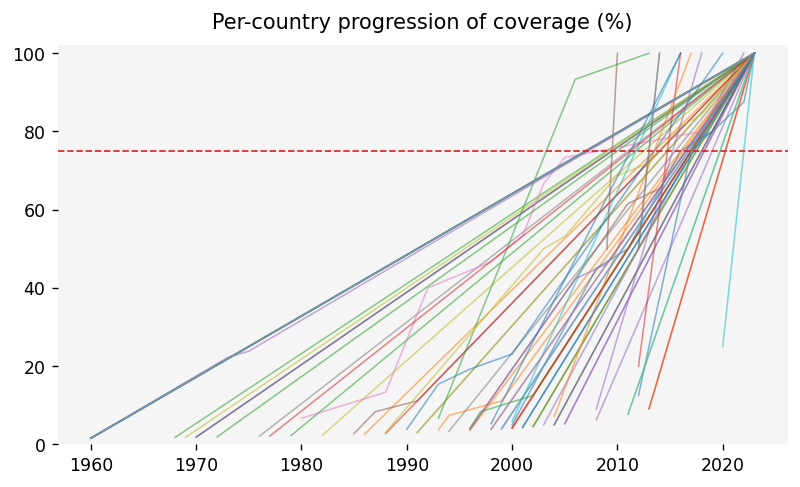

In [ ]:
# identify split year as year when countries have c. 75% behind them

dff = df.dropna(subset=["tgt_spread_lag"]).sort_values(["country", "year"])
dff["cum_share"] = (dff.groupby("country").cumcount() + 1) / dff.groupby("country")["year"].transform("count")
cross_years = dff.loc[dff["cum_share"] >= 0.75].groupby("country")["year"].min()
print(f"Median year for 75% coverage: {int(cross_years.median())}")

from functions.plot import coverage_progression

coverage_progression(df)

In [ ]:
# forward-fill

from functions.fill import fill

df_ff = fill(df)

# remove stale observations (fills from 3+ years)

fcols = [c for c in df_ff.columns if c.endswith("_f") and c != "fiw_f"]
ffilled_count = 0
removed_count = 0

for fcol in fcols:
    base = fcol[:-2]
    if base in df_ff.columns:
        m_ffilled = (df_ff[fcol] > 0) & (df_ff[fcol] <= 3) & df_ff[base].notna()
        m_removed = (df_ff[fcol] > 3) & df_ff[base].notna()
        ffilled_count += m_ffilled.sum()
        removed_count += m_removed.sum()
        df_ff.loc[df_ff[fcol] > 3, base] = np.nan

# fills summary

print(f"\n{removed_count:,} f-filled values removed due to staleness (3+ years), {ffilled_count:,} f-filled values remain")

from functions.fill import save_nulls_share

df_ff = save_nulls_share(df_ff, 'ffill')
print(f"Average observation null share decreased from {df_ff["nulls_init"].mean()*100:.0f} to {df_ff["nulls_ffill"].mean()*100:.0f} percent")
df_ff = df_ff.drop(columns=["nulls_init", "nulls_ffill"])

# save

df_ff.to_pickle("saved/df_ff.dat")

# drop _f metadata cols for further processing

fcols = [c for c in df_ff.columns if c.endswith("_f") and c != "fiw_f"]
df = df_ff.drop(columns=fcols)

F-filling Angola values
F-filling Armenia values
F-filling Australia values
F-filling Austria values
F-filling Bangladesh values
F-filling Belgium values
F-filling Botswana values
F-filling Brazil values
F-filling Bulgaria values
F-filling Canada values
F-filling Chile values
F-filling China values
F-filling Colombia values
F-filling Costa Rica values
F-filling Croatia values
F-filling Cyprus values
F-filling Czechia values
F-filling Côte d'Ivoire values
F-filling Denmark values
F-filling Estonia values
F-filling Fiji values
F-filling Finland values
F-filling France values
F-filling Germany values
F-filling Ghana values
F-filling Greece values
F-filling Hungary values
F-filling Iceland values
F-filling India values
F-filling Indonesia values
F-filling Ireland values
F-filling Israel values
F-filling Italy values
F-filling Japan values
F-filling Kyrgyzstan values
F-filling Latvia values
F-filling Lithuania values
F-filling Luxembourg values
F-filling Malaysia values
F-filling Malta valu

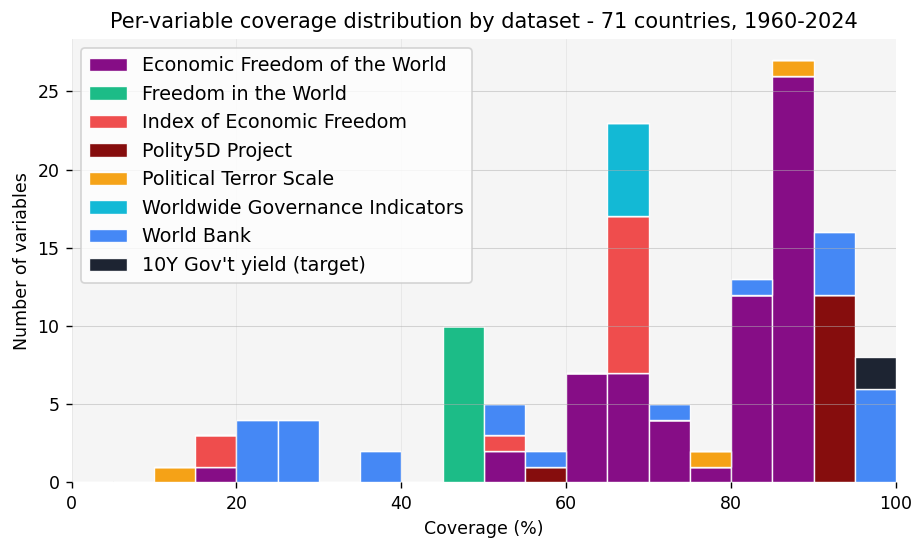

Removed 14 columns with less than 40% coverage, 269 remain
Removed ['efw_5diii_distorton_of_the_business_environment', 'ief_judicial_effectiveness', 'ief_fiscal_health', 'pts_pts_h', 'wb_iq_sci_mthd', 'wb_iq_sci_ovrl', 'wb_iq_sci_prdc', 'wb_iq_sci_srce', 'wb_iq_spi_ovrl', 'wb_iq_spi_pil2', 'wb_iq_spi_pil4', 'wb_iq_spi_pil5', 'wb_iq_wef_cust_xq', 'wb_iq_wef_port_xq']


In [ ]:
# show columns coverage

from functions.plot import coverage_per_variable

coverage_per_variable(df)

# drop columns with less than 40% coverage

coverage = df.notna().mean()
to_drop = coverage[coverage < 0.4].index
df = df.drop(columns=to_drop)
print(f"Removed {len(to_drop)} columns with less than 40% coverage, {df_ff.shape[1]} remain")
print("Removed", to_drop.tolist() )

In [ ]:
# create lagged variables for macro and IQ

from functions.utils import engineer_lag_vars

id_cols = ["country", "year", "iso_code_1", "iso_code_2", "region", "tgt_spread", "tgt_spread_lag"]
macro_vars = [c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_")]
iq_vars = [c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in id_cols))]

df = engineer_lag_vars(df, macro_vars, iq_vars)

# save dataset

df.to_pickle("saved/df.dat")

Added 130 engineered columns


In [ ]:
# create three datasets

id_cols = ["country", "year", "iso_code_1", "iso_code_2", "region"]
tgt_cols = ["tgt_spread_lag", "tgt_spread", "tgt_spread_prev"]

macro_iq = df.copy()
macro_only = df[id_cols + tgt_cols + [c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_")]]
iq_only = df[id_cols + tgt_cols + [c for c in df.columns if (not c.startswith("wb_") or c.startswith("wb_iq_")) and c not in id_cols + tgt_cols]]

# split into test and train

split_year = 2015
datasets = {"MACRO_ONLY": macro_only, "IQ_ONLY": iq_only, "MACRO+IQ": macro_iq}

macro_train, macro_test, iq_train, iq_test, macro_iq_train, macro_iq_test = [
    part
    for d in datasets.values()
    for part in (d[d["year"] <= split_year].copy(), d[d["year"] > split_year].copy())
]

# show shapes

for name, (train, test) in zip(
    datasets.keys(),
    [(macro_train, macro_test), (iq_train, iq_test), (macro_iq_train, macro_iq_test)]
):
    print(f"{name:<10} → train: {train.shape}, test: {test.shape}")

MACRO_ONLY → train: (1706, 47), test: (477, 47)
IQ_ONLY    → train: (1706, 214), test: (477, 214)
MACRO+IQ   → train: (1706, 253), test: (477, 253)


In [ ]:
from functions.utils import standardise

# standardise

macro_train_s, macro_test_s = standardise(macro_train, macro_test)
iq_train_s, iq_test_s = standardise(iq_train, iq_test)
macro_iq_train_s, macro_iq_test_s = standardise(macro_iq_train, macro_iq_test)

# check means and std. devs

from functions.utils import check_standardisation

check_standardisation(macro_train_s, "MACRO train")
check_standardisation(macro_test_s,  "MACRO test")
check_standardisation(iq_train_s,    "IQ train")
check_standardisation(iq_test_s,    "IQ test")
check_standardisation(macro_iq_train_s, "MACRO+IQ train")
check_standardisation(macro_iq_test_s, "MACRO+IQ test")

# run zero leakage checks

from functions.utils import assert_zero_leakage

assert_zero_leakage(macro_train, macro_test, macro_train_s, macro_test_s, "MACRO", 2015)
assert_zero_leakage(iq_train, iq_test, iq_train_s, iq_test_s, "IQ", 2015)
assert_zero_leakage(macro_iq_train, macro_iq_test, macro_iq_train_s, macro_iq_test_s, "MACRO+IQ", 2015)

# and save

datasets = {
    "macro_train": macro_train,
    "macro_test": macro_test,
    "iq_train": iq_train,
    "iq_test": iq_test,
    "macro_iq_train": macro_iq_train,
    "macro_iq_test": macro_iq_test,
    "macro_train_s": macro_train_s,
    "macro_test_s": macro_test_s,
    "iq_train_s": iq_train_s,
    "iq_test_s": iq_test_s,
    "macro_iq_train_s": macro_iq_train_s,
    "macro_iq_test_s": macro_iq_test_s,
}

for name, df in datasets.items():
    df.to_pickle(f"saved/{name}.dat")

— MACRO train —
Mean range: -0.0 → -0.0
Std  range: 1.0 → 1.0

— MACRO test —
Mean range: -0.245 → 0.579
Std  range: 0.028 → 3.001

— IQ train —
Mean range: 0.0 → 0.0
Std  range: 1.0 → 1.0

— IQ test —
Mean range: -1.92 → 4.729
Std  range: 0.02 → 5.967

— MACRO+IQ train —
Mean range: 0.0 → 0.0
Std  range: 1.0 → 1.0

— MACRO+IQ test —
Mean range: -1.92 → 4.729
Std  range: 0.02 → 5.967



# Models and tuning

## Mean-reversion

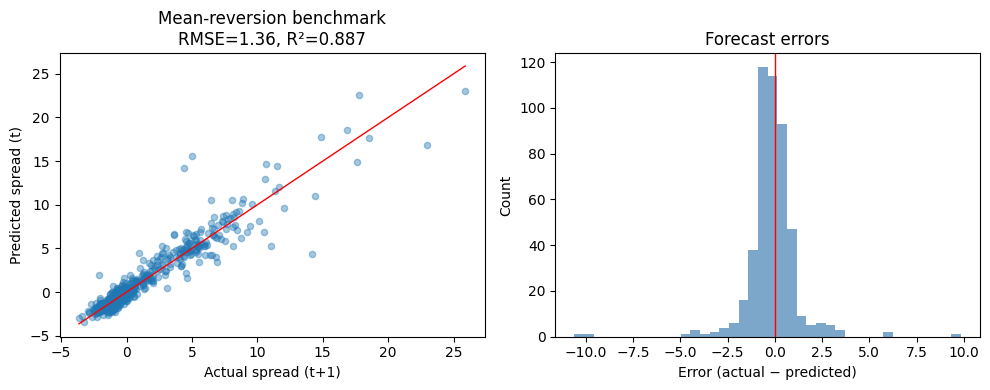

In [ ]:
# mean-reversion as benchmark

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

fullte = pd.read_pickle("saved/macro_iq_test.dat")[["country", "year", "tgt_spread", "tgt_spread_lag"]].dropna()
y_true = fullte["tgt_spread_lag"]
y_pred = fullte["tgt_spread"]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

# show fit and prediction error

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
axes[0].scatter(y_true, y_pred, alpha=0.4, s=20)
axes[0].plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             color="red", linestyle="-", lw=1)
axes[0].set_xlabel("Actual spread (t+1)")
axes[0].set_ylabel("Predicted spread (t)")
axes[0].set_title(f"Mean-reversion benchmark\nRMSE={rmse:.2f}, R²={r2:.3f}")

errors = y_true - y_pred
axes[1].hist(errors, bins=40, color="steelblue", alpha=0.7)
axes[1].axvline(0, color="red", lw=1)
axes[1].set_title("Forecast errors")
axes[1].set_xlabel("Error (actual − predicted)")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()


On average, the mean-reversion benchmark misses by about 1.3 percentage points (or 130 bps).

About 89% of the variation in next-year spreads is explained simply by the current spread — in other words, spreads are highly persistent.

In [ ]:
# how much of total variance is explained by between-country variance

df = fullte[["country", "tgt_spread_lag"]].dropna()
overall_mean = df["tgt_spread_lag"].mean()
n_i = df.groupby("country")["tgt_spread_lag"].count()
means_i = df.groupby("country")["tgt_spread_lag"].mean()

# weighted between-country variance

sst_between = ((n_i * (means_i - overall_mean)**2).sum()) / (len(df) - 1)
sst_total = ((df["tgt_spread_lag"] - overall_mean)**2).sum() / (len(df) - 1)
print(f"Share of between-country variance in total variance: {sst_between / sst_total:.2%}")

Share of between-country variance in total variance: 91.62%


About 92% of the variation in sovereign spreads reflects persistent cross-country differences, not year-to-year changes.

This means spreads mainly differ because of structural and institutional factors, while short-term movements are small and harder to predict.

Since current pricing already embeds much of this institutional information, IQ variables may be crowded out by the spread level itself in the regularised models.

## Lasso

In [ ]:
import numpy as np, pandas as pd, time
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error, r2_score

def run_lasso_spec(name_prefix,
                   y_name="tgt_spread_lag",
                   lam_factors=[0.001, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10],
                   agnostic=False,
                   include_spreads=True,
                   r2_zero=0.886890,
                   rmse_zero=1.355536):
    print(f"\n=== {name_prefix.upper()} MODEL ({'Agnostic' if agnostic else 'β=1'}) ===")
    start = time.time()
    datasets = {n: pd.read_pickle(f"saved/{n}.dat") for n in [
            f"{name_prefix}_train", f"{name_prefix}_test",
            f"{name_prefix}_train_s", f"{name_prefix}_test_s"]}

    drop_cols = ["country", "year", "iso_code_1", "iso_code_2", "region", "tgt_spread_lag"]
    if not include_spreads:
      drop_cols += ["tgt_spread", "tgt_spread_prev"]
    X_train = datasets[f"{name_prefix}_train_s"].drop(columns=drop_cols, errors="ignore")
    X_test  = datasets[f"{name_prefix}_test_s"].drop(columns=drop_cols, errors="ignore")
    y_train = datasets[f"{name_prefix}_train"][y_name]
    y_test  = datasets[f"{name_prefix}_test"][y_name]

    if agnostic:
        y_train_eff, y_test_eff = y_train, y_test
        spread_train, spread_test = None, None
    else:
        spread_train = datasets[f"{name_prefix}_train"]["tgt_spread"]
        spread_test  = datasets[f"{name_prefix}_test"]["tgt_spread"]
        mask_tr = spread_train.notna() & y_train.notna()
        mask_te = spread_test.notna() & y_test.notna()
        X_train, X_test = X_train.loc[mask_tr], X_test.loc[mask_te]
        y_train, y_test = y_train.loc[mask_tr], y_test.loc[mask_te]
        spread_train, spread_test = spread_train.loc[mask_tr], spread_test.loc[mask_te]
        y_train_eff = y_train - spread_train
        y_test_eff  = y_test - spread_test
        X_train = X_train.drop(columns=["tgt_spread"], errors="ignore")
        X_test  = X_test.drop(columns=["tgt_spread"], errors="ignore")

    alphas = np.logspace(-4, 1, 60)
    lcv = LassoCV(alphas=alphas, cv=5, max_iter=5000).fit(X_train, y_train_eff)
    results = []
    for lam in [lcv.alpha_ * f for f in lam_factors]:
        model = Lasso(alpha=lam, max_iter=5000).fit(X_train, y_train_eff)
        y_pred = model.predict(X_test)
        if not agnostic:
            y_pred = spread_test + y_pred
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        active = np.sum(model.coef_ != 0)
        results.append((lam, active, r2, rmse, model))

    df = pd.DataFrame(results, columns=["λ", "Active vars" if agnostic else "Additional active vars", "R²", "RMSE (p.p.)", "Model"])
    best = df.loc[df["R²"].idxmax()]
    elapsed = time.time() - start
    print(f"Finished in {elapsed:.2f}s | Best R²={best['R²']:.3f}, RMSE={best['RMSE (p.p.)']:.3f}, "
          f"Active={best[df.columns[1]]}")
    print(f"ΔR²={(best['R²'] - r2_zero) * 100:+.2f} p.p., "
          f"ΔRMSE={best['RMSE (p.p.)'] - rmse_zero:+.2f} p.p. "
          f"({(best['RMSE (p.p.)'] - rmse_zero) * 100:+.0f} bps)")
    fname = f"specs/lasso_{name_prefix}{'_agn_beta' if agnostic else ''}{'_wo_sprd' if not include_spreads else ''}.dat"
    df.to_pickle(fname)
    return {"name": name_prefix, "results": df, "best": best, "elapsed": elapsed}


specs = {"macro_agn": ("macro", True, True, [0.001, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10]),
         "macro":     ("macro", False, True, [1, 2, 5, 10, 20, 50, 100, 200, 400]),
         "iq_agn":    ("iq", True, True,  [0.001, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10]),
         "iq":        ("iq", False, True, [1, 2, 5, 10, 20, 50, 100]),
         "macro_iq_agn": ("macro_iq", True, True,  [0.001, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10]),
         "macro_iq":     ("macro_iq", False, True, [1, 2, 5, 10, 20, 50, 100, 200, 400]),
         "macro_iq_wo_sprds": ("macro_iq", True, False, [0.001, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10])}

results_all = {k: run_lasso_spec(v[0], lam_factors=v[3], agnostic=v[1], include_spreads=v[2])
               for k, v in specs.items()}

summary = pd.DataFrame([{"Specification": k.replace("_", " ").upper(),
                         **{c: r["best"][c] for c in ["λ", "R²", "RMSE (p.p.)"]},
                         "Active vars": r["best"].iloc[1],
                         "Time (s)": r["elapsed"]}
                        for k, r in results_all.items()])

print("\n=== SUMMARY ACROSS SPECIFICATIONS ===")
display(summary)


=== MACRO MODEL (Agnostic) ===
Finished in 7.24s | Best R²=0.776, RMSE=1.905, Active=28
ΔR²=-11.06 p.p., ΔRMSE=+0.55 p.p. (+55 bps)

=== MACRO MODEL (β=1) ===
Finished in 4.00s | Best R²=0.890, RMSE=1.336, Active=3
ΔR²=+0.33 p.p., ΔRMSE=-0.02 p.p. (-2 bps)

=== IQ MODEL (Agnostic) ===
Finished in 58.33s | Best R²=0.709, RMSE=2.172, Active=83
ΔR²=-17.75 p.p., ΔRMSE=+0.82 p.p. (+82 bps)

=== IQ MODEL (β=1) ===
Finished in 50.29s | Best R²=0.890, RMSE=1.337, Active=1
ΔR²=+0.31 p.p., ΔRMSE=-0.02 p.p. (-2 bps)

=== MACRO_IQ MODEL (Agnostic) ===
Finished in 88.49s | Best R²=0.794, RMSE=1.830, Active=123
ΔR²=-9.33 p.p., ΔRMSE=+0.47 p.p. (+47 bps)

=== MACRO_IQ MODEL (β=1) ===


### Macro with agnostic current spread

In [97]:
import numpy as np, pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

datasets = {}
names = ["macro_train", "macro_test","macro_train_s", "macro_test_s"]
for name in names:
    datasets[name] = pd.read_pickle(f"saved/{name}.dat")
drop_cols = ["country", "year", "iso_code_1", "iso_code_2", "region", "tgt_spread_lag"]
X_train = datasets["macro_train_s"].drop(columns=drop_cols)
X_test  = datasets["macro_test_s"].drop(columns=drop_cols)
y_train = datasets["macro_train"]["tgt_spread_lag"]
y_test  = datasets["macro_test"]["tgt_spread_lag"]

alphas = np.logspace(-4, 1, 60)
lasso = LassoCV(alphas=alphas, cv=5, max_iter=5000)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

results_list = []

for lam in [lasso.alpha_*0.001, lasso.alpha_*0.01, lasso.alpha_*0.025, lasso.alpha_*0.05,
    lasso.alpha_*0.1, lasso.alpha_*0.25, lasso.alpha_*0.5, lasso.alpha_*0.75,
    lasso.alpha_, lasso.alpha_*2, lasso.alpha_*5, lasso.alpha_*10]:
    model = Lasso(alpha=lam, max_iter=5000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    active = np.sum(model.coef_ != 0)
    results_list.append((lam, active, r2, rmse, model))

results_df = pd.DataFrame(results_list, columns=["λ", "Active vars", "R²", "RMSE (p.p.)", "Model"])
best_row = results_df.loc[results_df["R²"].idxmax()]

print("Summary across penalties:")
display(results_df[["λ", "Active vars", "R²", "RMSE (p.p.)"]])

best_model = best_row["Model"]
best_lambda = best_row["λ"]

coefs = pd.Series(best_model.coef_, index=X_train.columns, name="β")
nonzero = coefs[coefs != 0].sort_values(key=abs, ascending=False)
nonzero.index.name = "Variable"
print("\nVariables chosen in highest R² model:")
display(nonzero.to_frame())

r2_best = best_row["R²"]
r2_zero = 0.886890
rmse_best = best_row["RMSE (p.p.)"]
rmse_zero = 1.355536

print(f"\nLasso with {best_row['Active vars']} active vars vs. mean-reversion benchmark:")
print(f"ΔR² = {(r2_best - r2_zero)*100:+.2f} p.p.")
print(f"ΔRMSE = {rmse_best - rmse_zero:+.2f} p.p. ({(rmse_best-rmse_zero)*100:.0f} bps)")

Summary across penalties:


,λ,Active vars,R²,RMSE (p.p.)
0,0.000441,70,0.762006,1.965343
1,0.004406,57,0.755805,1.990785
2,0.011016,41,0.769183,1.935483
3,0.022031,34,0.776161,1.906003
4,0.044062,28,0.776324,1.905308
5,0.110156,20,0.753948,1.998337
6,0.220312,13,0.710227,2.168628
7,0.330468,11,0.661584,2.343587
8,0.440624,9,0.610831,2.513186
9,0.881247,4,0.435860,3.025861



Variables chosen in highest R² model:


,β
Variable,
wb_fp_cpi_totl_zg_ma3,-11.741809
wb_ny_gdp_defl_kd_zg_ma3,10.200208
wb_ny_gdp_defl_kd_zg,4.922605
tgt_spread,3.996077
wb_fp_cpi_totl_zg,-2.767026
wb_ny_gdp_defl_kd_zg_delta,1.674669
tgt_spread__mis,0.773139
wb_ny_gdp_pcap_kd_ma3,-0.697568
wb_gc_dod_totl_gd_zs_delta__mis,0.656011



Lasso with 28 active vars vs. mean-reversion benchmark:
ΔR² = -11.06 p.p.
ΔRMSE = +0.55 p.p. (55 bps)


### IQ with agnostic current spread

In [99]:
import numpy as np, pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

datasets = {}
names = ["iq_train", "iq_test","iq_train_s", "iq_test_s"]
for name in names:
    datasets[name] = pd.read_pickle(f"saved/{name}.dat")
drop_cols = ["country", "year", "iso_code_1", "iso_code_2", "region", "tgt_spread_lag"]
X_train = datasets["iq_train_s"].drop(columns=drop_cols)
X_test  = datasets["iq_test_s"].drop(columns=drop_cols)
y_train = datasets["iq_train"]["tgt_spread_lag"]
y_test  = datasets["iq_test"]["tgt_spread_lag"]

alphas = np.logspace(-4, 1, 60)
lasso = LassoCV(alphas=alphas, cv=5, max_iter=5000)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

results_list = []

for lam in [lasso.alpha_*0.001, lasso.alpha_*0.01, lasso.alpha_*0.025, lasso.alpha_*0.05,
    lasso.alpha_*0.1, lasso.alpha_*0.25, lasso.alpha_*0.5, lasso.alpha_*0.75,
    lasso.alpha_, lasso.alpha_*2, lasso.alpha_*5, lasso.alpha_*10]:
    model = Lasso(alpha=lam, max_iter=5000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    active = np.sum(model.coef_ != 0)
    results_list.append((lam, active, r2, rmse, model))

results_df = pd.DataFrame(results_list, columns=["λ", "Active vars", "R²", "RMSE (p.p.)", "Model"])
best_row = results_df.loc[results_df["R²"].idxmax()]

print("Summary across penalties:")
display(results_df[["λ", "Active vars", "R²", "RMSE (p.p.)"]])

best_model = best_row["Model"]
best_lambda = best_row["λ"]

coefs = pd.Series(best_model.coef_, index=X_train.columns, name="β")
nonzero = coefs[coefs != 0].sort_values(key=abs, ascending=False)
nonzero.index.name = "Variable"
print("\nVariables chosen in highest R² model:")
display(nonzero.to_frame())

r2_best = best_row["R²"]
r2_zero = 0.886890
rmse_best = best_row["RMSE (p.p.)"]
rmse_zero = 1.355536

print(f"\nLasso with {best_row['Active vars']} active vars vs. mean-reversion benchmark:")
print(f"ΔR² = {(r2_best - r2_zero)*100:+.2f} p.p.")
print(f"ΔRMSE = {rmse_best - rmse_zero:+.2f} p.p. ({(rmse_best-rmse_zero)*100:.0f} bps)")

Summary across penalties:


,λ,Active vars,R²,RMSE (p.p.)
0,0.000536,347,0.158871,3.694765
1,0.005356,223,0.472102,2.927053
2,0.013389,166,0.629903,2.450832
3,0.026778,129,0.681004,2.275350
4,0.053557,83,0.709409,2.171685
5,0.133892,32,0.705997,2.184397
6,0.267783,8,0.686041,2.257314
7,0.401675,6,0.674232,2.299376
8,0.535567,6,0.658049,2.355797
9,1.071133,4,0.558415,2.677088



Variables chosen in highest R² model:


,β
Variable,
tgt_spread__mis,3.903466e+00
tgt_spread,3.069121e+00
pts_pts_s,2.140534e+00
pts_pts_a,-1.069970e+00
ief_monetary_freedom,-9.219873e-01
...,...
efw_3a_money_growth_delta3,1.040013e-02
efw_5bii_hiring_and_firing_regulations_delta3,-6.935626e-03
efw_5dii_business_permits_delta3,1.456887e-03



Lasso with 83 active vars vs. mean-reversion benchmark:
ΔR² = -17.75 p.p.
ΔRMSE = +0.82 p.p. (82 bps)


### Macro + IQ with agnostic spread

In [100]:
import numpy as np, pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

datasets = {}
names = ["macro_iq_train", "macro_iq_test","macro_iq_train_s", "macro_iq_test_s"]
for name in names:
    datasets[name] = pd.read_pickle(f"saved/{name}.dat")
drop_cols = ["country", "year", "iso_code_1", "iso_code_2", "region", "tgt_spread_lag"]
X_train = datasets["macro_iq_train_s"].drop(columns=drop_cols)
X_test  = datasets["macro_iq_test_s"].drop(columns=drop_cols)
y_train = datasets["macro_iq_train"]["tgt_spread_lag"]
y_test  = datasets["macro_iq_test"]["tgt_spread_lag"]

alphas = np.logspace(-4, 1, 60)
lasso = LassoCV(alphas=alphas, cv=5, max_iter=5000)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

results_list = []

for lam in [lasso.alpha_*0.001, lasso.alpha_*0.01, lasso.alpha_*0.025, lasso.alpha_*0.05,
    lasso.alpha_*0.1, lasso.alpha_*0.25, lasso.alpha_*0.5, lasso.alpha_*0.75,
    lasso.alpha_, lasso.alpha_*2, lasso.alpha_*5, lasso.alpha_*10]:
    model = Lasso(alpha=lam, max_iter=5000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    active = np.sum(model.coef_ != 0)
    results_list.append((lam, active, r2, rmse, model))

results_df = pd.DataFrame(results_list, columns=["λ", "Active vars", "R²", "RMSE (p.p.)", "Model"])
best_row = results_df.loc[results_df["R²"].idxmax()]

print("Summary across penalties:")
display(results_df[["λ", "Active vars", "R²", "RMSE (p.p.)"]])

best_model = best_row["Model"]
best_lambda = best_row["λ"]

coefs = pd.Series(best_model.coef_, index=X_train.columns, name="β")
nonzero = coefs[coefs != 0].sort_values(key=abs, ascending=False)
nonzero.index.name = "Variable"
print("\nVariables chosen in highest R² model:")
display(nonzero.to_frame())

r2_best = best_row["R²"]
r2_zero = 0.886890
rmse_best = best_row["RMSE (p.p.)"]
rmse_zero = 1.355536

print(f"\nLasso with {best_row['Active vars']} active vars vs. mean-reversion benchmark:")
print(f"ΔR² = {(r2_best - r2_zero)*100:+.2f} p.p.")
print(f"ΔRMSE = {rmse_best - rmse_zero:+.2f} p.p. ({(rmse_best-rmse_zero)*100:.0f} bps)")

Summary across penalties:


,λ,Active vars,R²,RMSE (p.p.)
0,0.000298,400,0.537126,2.740862
1,0.002982,299,0.713160,2.157624
2,0.007456,215,0.743850,2.038933
3,0.014912,162,0.764818,1.953700
4,0.029825,123,0.793570,1.830383
5,0.074562,60,0.783306,1.875335
6,0.149124,28,0.755287,1.992893
7,0.223685,17,0.730254,2.092346
8,0.298247,14,0.703058,2.195289
9,0.596494,11,0.570368,2.640610



Variables chosen in highest R² model:


,β
Variable,
wb_fp_cpi_totl_zg_ma3,-9.807993
wb_ny_gdp_defl_kd_zg_ma3,7.925316
wb_ny_gdp_defl_kd_zg,7.644496
wb_fp_cpi_totl_zg,-4.774521
tgt_spread,3.245529
...,...
efw_5cii_bureacracy_costs_delta3,0.004100
ief_government_integrity_delta3,0.004026
efw_5ci_regulatory_burden,0.002559



Lasso with 123 active vars vs. mean-reversion benchmark:
ΔR² = -9.33 p.p.
ΔRMSE = +0.47 p.p. (47 bps)


### Macro with β=1 current spread

In [75]:
import numpy as np, pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

datasets = {}
names = ["macro_train", "macro_test", "macro_train_s", "macro_test_s"]
for name in names: datasets[name] = pd.read_pickle(f"saved/{name}.dat")

drop_cols = ["country","year","iso_code_1","iso_code_2","region","tgt_spread_lag"]
X_train_full = datasets["macro_train_s"].drop(columns=drop_cols, errors="ignore")
X_test_full = datasets["macro_test_s"].drop(columns=drop_cols, errors="ignore")
spread_train = datasets["macro_train"]["tgt_spread"]
spread_test = datasets["macro_test"]["tgt_spread"]
y_train = datasets["macro_train"]["tgt_spread_lag"]
y_test = datasets["macro_test"]["tgt_spread_lag"]

mask_tr = spread_train.notna() & y_train.notna()
mask_te = spread_test.notna() & y_test.notna()
X_train, y_train, spread_train = X_train_full.loc[mask_tr], y_train.loc[mask_tr], spread_train.loc[mask_tr]
X_test, y_test, spread_test = X_test_full.loc[mask_te], y_test.loc[mask_te], spread_test.loc[mask_te]

y_train_resid = y_train - spread_train
y_test_resid = y_test - spread_test
X_train = X_train.drop(columns=["tgt_spread"], errors="ignore")
X_test = X_test.drop(columns=["tgt_spread"], errors="ignore")

alphas = np.logspace(-4, 1, 60)
lasso = LassoCV(alphas=alphas, cv=5, max_iter=5000)
lasso.fit(X_train, y_train_resid)

from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

results_list = []

for lam in [lasso.alpha_, lasso.alpha_*2, lasso.alpha_*5, lasso.alpha_*10,
            lasso.alpha_*20, lasso.alpha_*50, lasso.alpha_*100, lasso.alpha_*200, lasso.alpha_*400]:
    model = Lasso(alpha=lam, max_iter=5000)
    model.fit(X_train, y_train_resid)
    y_pred_resid = model.predict(X_test)
    y_pred = spread_test + y_pred_resid
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    active = np.sum(model.coef_ != 0)
    results_list.append((lam, active, r2, rmse, model))

results_df = pd.DataFrame(results_list, columns=["λ", "Additional active vars", "R²" ,"RMSE (p.p.)", "Model"])
best_row = results_df.loc[results_df["R²"].idxmax()]
print("Summary across penalties:")
display(results_df[["λ","Additional active vars","R²","RMSE (p.p.)"]])
best_model = best_row["Model"]
best_lambda = best_row["λ"]
coefs = pd.Series(best_model.coef_, index=X_train.columns)
nonzero = coefs[coefs != 0].sort_values(key=abs, ascending=False)
nonzero = nonzero.rename_axis("Variable").reset_index().rename(columns={0:"Coefficient"})
print("\nVariables chosen in highest R² model (in addition to β=1 tgt_spread):")
display(nonzero)

r2_best = best_row["R²"]
r2_zero = results_df.loc[results_df["Additional active vars"] == 0, "R²"].iloc[0]
rmse_best = best_row["RMSE (p.p.)"]
rmse_zero = results_df.loc[results_df["Additional active vars"] == 0, "RMSE (p.p.)"].iloc[0]
print(f"\nLasso with β=1 tgt_spread and {best_row['Additional active vars']} additional macro vars vs. mean-reversion benchmark:")
print(f"ΔR² - {(r2_best - r2_zero)*100:+.2f} p.p.")
print(f"ΔRMSE - {rmse_best - rmse_zero:+.2f} p.p. ({(rmse_best-rmse_zero)*100:.0f} bps)")

Summary across penalties:


,λ,Additional active vars,R²,RMSE (p.p.)
0,0.019415,29,0.856234,1.528225
1,0.038830,23,0.867287,1.468305
2,0.097075,15,0.875777,1.420563
3,0.194149,7,0.880375,1.394024
4,0.388298,4,0.883703,1.374500
5,0.970746,3,0.890170,1.335732
6,1.941492,2,0.887855,1.349736
7,3.882984,1,0.886987,1.354950
8,7.765968,0,0.886890,1.355536



Variables chosen in highest R² model (in addition to β=1 tgt_spread):


,Variable,Coefficient
0,wb_fp_cpi_totl_zg_delta,2.017431
1,wb_fp_cpi_totl_zg_ma3,-1.819832
2,tgt_spread_prev,-0.276204



Lasso with β=1 tgt_spread and 3 additional macro vars vs. mean-reversion benchmark:
ΔR² - +0.33 p.p.
ΔRMSE - -0.02 p.p. (-2 bps)


### IQ with β=1 current spread

In [101]:
import numpy as np, pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

datasets = {}
names = ["iq_train", "iq_test", "iq_train_s", "iq_test_s"]
for name in names: datasets[name] = pd.read_pickle(f"saved/{name}.dat")

drop_cols = ["country","year","iso_code_1","iso_code_2","region","tgt_spread_lag"]
X_train_full = datasets["iq_train_s"].drop(columns=drop_cols, errors="ignore")
X_test_full = datasets["iq_test_s"].drop(columns=drop_cols, errors="ignore")
spread_train = datasets["iq_train"]["tgt_spread"]
spread_test = datasets["iq_test"]["tgt_spread"]
y_train = datasets["iq_train"]["tgt_spread_lag"]
y_test = datasets["iq_test"]["tgt_spread_lag"]

mask_tr = spread_train.notna() & y_train.notna()
mask_te = spread_test.notna() & y_test.notna()
X_train, y_train, spread_train = X_train_full.loc[mask_tr], y_train.loc[mask_tr], spread_train.loc[mask_tr]
X_test, y_test, spread_test = X_test_full.loc[mask_te], y_test.loc[mask_te], spread_test.loc[mask_te]

y_train_resid = y_train - spread_train
y_test_resid = y_test - spread_test
X_train = X_train.drop(columns=["tgt_spread"], errors="ignore")
X_test = X_test.drop(columns=["tgt_spread"], errors="ignore")

alphas = np.logspace(-4, 1, 60)
lasso = LassoCV(alphas=alphas, cv=5, max_iter=5000)
lasso.fit(X_train, y_train_resid)

from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

results_list = []

for lam in [lasso.alpha_, lasso.alpha_*2, lasso.alpha_*5, lasso.alpha_*10,
            lasso.alpha_*20, lasso.alpha_*50, lasso.alpha_*100]:
    model = Lasso(alpha=lam, max_iter=5000)
    model.fit(X_train, y_train_resid)
    y_pred_resid = model.predict(X_test)
    y_pred = spread_test + y_pred_resid
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    active = np.sum(model.coef_ != 0)
    results_list.append((lam, active, r2, rmse, model))

results_df = pd.DataFrame(results_list, columns=["λ", "Additional active vars", "R²" ,"RMSE (p.p.)", "Model"])
best_row = results_df.loc[results_df["R²"].idxmax()]
print("Summary across penalties:")
display(results_df[["λ","Additional active vars","R²","RMSE (p.p.)"]])
best_model = best_row["Model"]
best_lambda = best_row["λ"]
coefs = pd.Series(best_model.coef_, index=X_train.columns)
nonzero = coefs[coefs != 0].sort_values(key=abs, ascending=False)
nonzero = nonzero.rename_axis("Variable").reset_index().rename(columns={0:"Coefficient"})
print("\nVariables chosen in highest R² model (in addition to β=1 tgt_spread):")
display(nonzero)

r2_best = best_row["R²"]
r2_zero = results_df.loc[results_df["Additional active vars"] == 0, "R²"].iloc[0]
rmse_best = best_row["RMSE (p.p.)"]
rmse_zero = results_df.loc[results_df["Additional active vars"] == 0, "RMSE (p.p.)"].iloc[0]
print(f"\nLasso with β=1 tgt_spread and {best_row['Additional active vars']} additional variable vs. mean-reversion benchmark:")
print(f"ΔR² - {(r2_best - r2_zero)*100:+.2f} p.p.")
print(f"ΔRMSE - {rmse_best - rmse_zero:+.2f} p.p. ({(rmse_best-rmse_zero)*100:.0f} bps)")

Summary across penalties:


,λ,Additional active vars,R²,RMSE (p.p.)
0,0.042376,89,0.817446,1.722088
1,0.084752,48,0.827805,1.672514
2,0.211879,10,0.845168,1.585951
3,0.423759,6,0.852877,1.545965
4,0.847517,1,0.850803,1.556827
5,2.118794,1,0.889942,1.337119
6,4.237587,0,0.886890,1.355536



Variables chosen in highest R² model (in addition to β=1 tgt_spread):


,Variable,Coefficient
0,tgt_spread_prev,-0.909446



Lasso with β=1 tgt_spread and 1 additional variable vs. mean-reversion benchmark:
ΔR² - +0.31 p.p.
ΔRMSE - -0.02 p.p. (-2 bps)


In [103]:
row = results_df.loc[results_df["Additional active vars"]==6].iloc[0]
model = row["Model"]
coefs = pd.Series(model.coef_, index=X_train.columns)
nonzero = coefs[coefs != 0].sort_values(key=abs, ascending=False)
nonzero = nonzero.rename_axis("Variable").reset_index().rename(columns={0:"Coefficient"})
print("\nVariables chosen in third-highest R² model (in addition to β=1 tgt_spread):")
display(nonzero)


Variables chosen in third-highest R² model (in addition to β=1 tgt_spread):


,Variable,Coefficient
0,tgt_spread_prev,-2.658947
1,efw_5ciii_impartial_public_administration,-0.167208
2,efw_4b_regulatory_trade_barriers,-0.108734
3,efw_2e_legal_integrity,-0.105968
4,efw_2a_judicial_independence,-0.025674
5,efw_3a_money_growth,-0.016259


### Macro + IQ with β=1 current spread

In [104]:
import numpy as np, pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

datasets = {}
names = ["macro_iq_train", "macro_iq_test", "macro_iq_train_s", "macro_iq_test_s"]
for name in names: datasets[name] = pd.read_pickle(f"saved/{name}.dat")

drop_cols = ["country","year","iso_code_1","iso_code_2","region","tgt_spread_lag"]
X_train_full = datasets["macro_iq_train_s"].drop(columns=drop_cols, errors="ignore")
X_test_full = datasets["macro_iq_test_s"].drop(columns=drop_cols, errors="ignore")
spread_train = datasets["macro_iq_train"]["tgt_spread"]
spread_test = datasets["macro_iq_test"]["tgt_spread"]
y_train = datasets["macro_iq_train"]["tgt_spread_lag"]
y_test = datasets["macro_iq_test"]["tgt_spread_lag"]

mask_tr = spread_train.notna() & y_train.notna()
mask_te = spread_test.notna() & y_test.notna()
X_train, y_train, spread_train = X_train_full.loc[mask_tr], y_train.loc[mask_tr], spread_train.loc[mask_tr]
X_test, y_test, spread_test = X_test_full.loc[mask_te], y_test.loc[mask_te], spread_test.loc[mask_te]

y_train_resid = y_train - spread_train
y_test_resid = y_test - spread_test
X_train = X_train.drop(columns=["tgt_spread"], errors="ignore")
X_test = X_test.drop(columns=["tgt_spread"], errors="ignore")

alphas = np.logspace(-4, 1, 60)
lasso = LassoCV(alphas=alphas, cv=5, max_iter=5000)
lasso.fit(X_train, y_train_resid)

from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

results_list = []

for lam in [lasso.alpha_, lasso.alpha_*2, lasso.alpha_*5, lasso.alpha_*10,
            lasso.alpha_*20, lasso.alpha_*50, lasso.alpha_*100, lasso.alpha_*200, lasso.alpha_*400]:
    model = Lasso(alpha=lam, max_iter=5000)
    model.fit(X_train, y_train_resid)
    y_pred_resid = model.predict(X_test)
    y_pred = spread_test + y_pred_resid
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    active = np.sum(model.coef_ != 0)
    results_list.append((lam, active, r2, rmse, model))

results_df = pd.DataFrame(results_list, columns=["λ", "Additional active vars", "R²" ,"RMSE (p.p.)", "Model"])
best_row = results_df.loc[results_df["R²"].idxmax()]
print("Summary across penalties:")
display(results_df[["λ","Additional active vars","R²","RMSE (p.p.)"]])
best_model = best_row["Model"]
best_lambda = best_row["λ"]
coefs = pd.Series(best_model.coef_, index=X_train.columns)
nonzero = coefs[coefs != 0].sort_values(key=abs, ascending=False)
nonzero = nonzero.rename_axis("Variable").reset_index().rename(columns={0:"Coefficient"})
print("\nVariables chosen in highest R² model (in addition to β=1 tgt_spread):")
display(nonzero)

r2_best = best_row["R²"]
r2_zero = results_df.loc[results_df["Additional active vars"] == 0, "R²"].iloc[0]
rmse_best = best_row["RMSE (p.p.)"]
rmse_zero = results_df.loc[results_df["Additional active vars"] == 0, "RMSE (p.p.)"].iloc[0]
print(f"\nLasso with β=1 tgt_spread and {best_row['Additional active vars']} additional variable vs. mean-reversion benchmark:")
print(f"ΔR² - {(r2_best - r2_zero)*100:+.2f} p.p.")
print(f"ΔRMSE - {rmse_best - rmse_zero:+.2f} p.p. ({(rmse_best-rmse_zero)*100:.0f} bps)")

Summary across penalties:


,λ,Additional active vars,R²,RMSE (p.p.)
0,0.019415,135,0.839756,1.613431
1,0.038830,79,0.865628,1.477454
2,0.097075,26,0.877999,1.407801
3,0.194149,10,0.884288,1.371038
4,0.388298,6,0.887433,1.352276
5,0.970746,3,0.890170,1.335732
6,1.941492,2,0.887855,1.349736
7,3.882984,1,0.886987,1.354950
8,7.765968,0,0.886890,1.355536



Variables chosen in highest R² model (in addition to β=1 tgt_spread):


,Variable,Coefficient
0,wb_fp_cpi_totl_zg_delta,2.017431
1,wb_fp_cpi_totl_zg_ma3,-1.819832
2,tgt_spread_prev,-0.276204



Lasso with β=1 tgt_spread and 3 additional variable vs. mean-reversion benchmark:
ΔR² - +0.33 p.p.
ΔRMSE - -0.02 p.p. (-2 bps)


In [105]:
row = results_df.loc[results_df["Additional active vars"]==6].iloc[0]
model = row["Model"]
coefs = pd.Series(model.coef_, index=X_train.columns)
nonzero = coefs[coefs != 0].sort_values(key=abs, ascending=False)
nonzero = nonzero.rename_axis("Variable").reset_index().rename(columns={0:"Coefficient"})
print("\nVariables chosen in third-highest R² model (in addition to β=1 tgt_spread):")
display(nonzero)


Variables chosen in third-highest R² model (in addition to β=1 tgt_spread):


,Variable,Coefficient
0,wb_fp_cpi_totl_zg_delta,2.959767
1,wb_fp_cpi_totl_zg,-2.172986
2,tgt_spread_prev,-1.057011
3,wb_ny_gdp_petr_rt_zs_delta,-0.085026
4,efw_3b_standard_deviation_of_inflation,-0.082872
5,efw_3_sound_money,-0.073496


### IQ without current spread

In [98]:
import numpy as np, pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

datasets = {}
names = ["iq_train", "iq_test","iq_train_s", "iq_test_s"]
for name in names:
    datasets[name] = pd.read_pickle(f"saved/{name}.dat")
drop_cols = ["country", "year", "iso_code_1", "iso_code_2", "region", "tgt_spread_lag", "tgt_spread", "tgt_spread_prev"]
X_train = datasets["iq_train_s"].drop(columns=drop_cols)
X_test  = datasets["iq_test_s"].drop(columns=drop_cols)
y_train = datasets["iq_train"]["tgt_spread_lag"]
y_test  = datasets["iq_test"]["tgt_spread_lag"]

alphas = np.logspace(-4, 1, 60)
lasso = LassoCV(alphas=alphas, cv=5, max_iter=5000)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

results_list = []

for lam in [lasso.alpha_*0.001, lasso.alpha_*0.01, lasso.alpha_*0.025, lasso.alpha_*0.05,
    lasso.alpha_*0.1, lasso.alpha_*0.25, lasso.alpha_*0.5, lasso.alpha_*0.75,
    lasso.alpha_, lasso.alpha_*2, lasso.alpha_*5, lasso.alpha_*10]:
    model = Lasso(alpha=lam, max_iter=5000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    active = np.sum(model.coef_ != 0)
    results_list.append((lam, active, r2, rmse, model))

results_df = pd.DataFrame(results_list, columns=["λ", "Active vars", "R²", "RMSE (p.p.)", "Model"])
best_row = results_df.loc[results_df["R²"].idxmax()]

print("Summary across penalties:")
display(results_df[["λ", "Active vars", "R²", "RMSE (p.p.)"]])

best_model = best_row["Model"]
best_lambda = best_row["λ"]

coefs = pd.Series(best_model.coef_, index=X_train.columns, name="β")
nonzero = coefs[coefs != 0].sort_values(key=abs, ascending=False)
nonzero.index.name = "Variable"
print("\nVariables chosen in highest R² model:")
display(nonzero.to_frame())

r2_best = best_row["R²"]
r2_zero = 0.886890
rmse_best = best_row["RMSE (p.p.)"]
rmse_zero = 1.355536

print(f"\nUnconstrained Lasso with {best_row['Active vars']} active vars vs. mean-reversion benchmark:")
print(f"ΔR² = {(r2_best - r2_zero)*100:+.2f} p.p.")
print(f"ΔRMSE = {rmse_best - rmse_zero:+.2f} p.p. ({(rmse_best-rmse_zero)*100:.0f} bps)")

Summary across penalties:


,λ,Active vars,R²,RMSE (p.p.)
0,0.000166,380,-0.340692,4.664661
1,0.001661,318,0.023588,3.980817
2,0.004152,269,0.136371,3.743857
3,0.008304,216,0.243356,3.504302
4,0.016609,178,0.389086,3.148805
5,0.041522,129,0.460777,2.958284
6,0.083044,78,0.481645,2.900475
7,0.124566,54,0.466001,2.943918
8,0.166088,34,0.438165,3.019675
9,0.332177,9,0.398725,3.123864



Variables chosen in highest R² model:


,β
Variable,
pts_pts_s,2.588734e+00
ief_monetary_freedom,-1.324122e+00
tgt_spread_prev__mis,1.282106e+00
efw_4aii_mean_tariff_rate__mis,1.200251e+00
pts_pts_a,-1.128573e+00
...,...
p5d_durable_delta3__mis,1.281624e-16
p5d_parcomp_delta3__mis,1.281624e-16
ief_trade_freedom__mis,7.035393e-17



Unconstrained Lasso with 78 active vars vs. mean-reversion benchmark:
ΔR² = -40.52 p.p.
ΔRMSE = +1.54 p.p. (154 bps)
